reference: https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/kfold/baseline-cnn-mnist.ipynb

## Import

In [1]:
import os
import time
from pprint import pprint
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [3]:
from util import *
DATA_ADDRESS 

'./data/'

In [4]:
torch.cuda.is_available()

True

## Settings

In [5]:
# Random seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 640

# Architecture
num_classes = 200



## Dataset

In [6]:
FILE_DIR = DATA_ADDRESS+"VOiCES_devkit/"
TRAIN_DIR = DATA_ADDRESS+'preprocessed/train/'

In [7]:
def load_train(train_files):
    ls_X_trian = []
    for train_file in tqdm(train_files):
        file_dir = os.path.join(TRAIN_DIR, train_file)
        ls_X_trian.append(load_pickle(file_dir))
    return np.concatenate(ls_X_trian, axis=0)

In [8]:

file_prefix = 'mfcc_len5_fft2048_mels128_mfcc17_'

# List all files in the directory
files = os.listdir(TRAIN_DIR)
pprint(files)


['mel_len15_fft2048_mels128_mfcc17_0-499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_1000-1499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_10000-10499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_10500-10999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_11000-11499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_11500-11999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_12000-12499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_12500-12799.pkl',
 'mel_len15_fft2048_mels128_mfcc17_1500-1999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_2000-2499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_2500-2999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_3000-3499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_3500-3999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_4000-4499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_4500-4999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_500-999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_5000-5499.pkl',
 'mel_len15_fft2048_mels128_mfcc17_5500-5999.pkl',
 'mel_len15_fft2048_mels128_mfcc17_6000-6499.pkl',
 'mel_len15_fft2048_mels1

In [9]:
# Filter files that start with the specified prefix
train_files_mfcc = [file for file in files if file.startswith(file_prefix)]
pprint(train_files_mfcc)

['mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_1000-1499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_10000-10499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_10500-10999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_11000-11499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_11500-11999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_12000-12499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_12500-12999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_13000-13499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_13500-13999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_14000-14499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_14500-14999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_1500-1999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_15000-15499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_15500-15999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_16000-16499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_16500-16999.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_17000-17499.pkl',
 'mfcc_len5_fft2048_mels128_mfcc17_17500-17999.pkl',
 'm

In [10]:
X = load_train(train_files_mfcc)
X.shape

100%|██████████| 100/100 [00:00<00:00, 385.80it/s]


(49664, 17, 216)

In [11]:
df = pd.read_pickle(DATA_ADDRESS+"df_5s.pkl")
df

,origin_folder,speaker,distractor,room,category,filename
0,distant-16k/speech/test/rm2/musi/sp6643,6643,musi,rm2,test,5seconds-16k/speech/test/rm2/musi/sp6643/Lab41...
1,distant-16k/speech/test/rm2/musi/sp6643,6643,musi,rm2,test,5seconds-16k/speech/test/rm2/musi/sp6643/Lab41...
2,distant-16k/speech/test/rm2/musi/sp6643,6643,musi,rm2,test,5seconds-16k/speech/test/rm2/musi/sp6643/Lab41...
3,distant-16k/speech/test/rm2/musi/sp6643,6643,musi,rm2,test,5seconds-16k/speech/test/rm2/musi/sp6643/Lab41...
4,distant-16k/speech/test/rm2/musi/sp6643,6643,musi,rm2,test,5seconds-16k/speech/test/rm2/musi/sp6643/Lab41...
...,...,...,...,...,...,...
74459,distant-16k/speech/test/rm3/tele/sp0166,0166,tele,rm3,test,5seconds-16k/speech/test/rm3/tele/sp0166/Lab41...
74460,distant-16k/speech/test/rm3/tele/sp0166,0166,tele,rm3,test,5seconds-16k/speech/test/rm3/tele/sp0166/Lab41...
74461,distant-16k/speech/test/rm3/tele/sp0166,0166,tele,rm3,test,5seconds-16k/speech/test/rm3/tele/sp0166/Lab41...
74462,distant-16k/speech/test/rm3/tele/sp0166,0166,tele,rm3,test,5seconds-16k/speech/test/rm3/tele/sp0166/Lab41...


In [57]:
y = np.array(df[df['category']=='train']['speaker']).astype('float32')
y

array([1961, 1961, 1961, ..., 1536, 1536, 1536])

load to dataloader from numpy array:

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader

In [58]:
tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_x = tensor_x.unsqueeze(1) # Add a channel dimension
tensor_y = torch.Tensor(y)
print("X shape",tensor_x.shape)
print("y shape",tensor_y.shape)

train_dataset = TensorDataset(tensor_x,tensor_y) 


X shape torch.Size([49664, 1, 17, 216])
y shape torch.Size([49664])


In [59]:
# split to train and valid datasets
train_dataset, valid_dataset = random_split(train_dataset, lengths=[0.8, 0.2])

In [60]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=4,
    shuffle=False,
)

In [61]:
train_loader.dataset

In [62]:
train_features, train_labels = next(iter(train_loader))

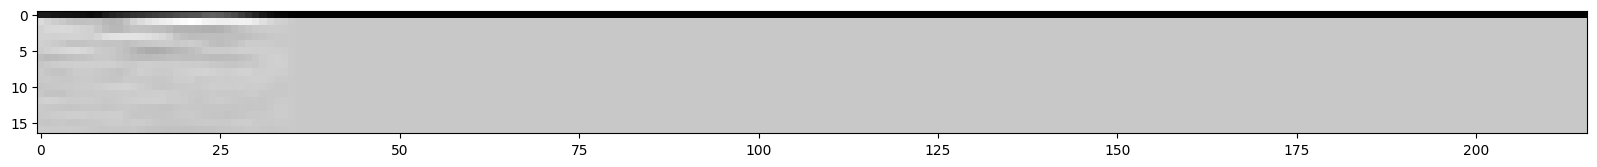

In [75]:
import matplotlib.pyplot as plt
img = train_features[200].squeeze()
plt.figure(figsize=(20,10))
plt.imshow(img, cmap="gray")
plt.show()

## Model

In [26]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [16]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=1,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64 * (17 // 4) * (216 // 4), 1028),
            torch.nn.ReLU(),
            torch.nn.Linear(1028, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = PyTorchCNN(num_classes=num_classes).to(device)

In [18]:
# Generated

class PyTorchCNN(nn.Module):
    def __init__(self, num_classes):
        super(PyTorchCNN, self).__init__()
        
        # Assuming input size is (batch_size, 1, 17, 216), if not, adjust accordingly.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Calculate the size of the flattened features after the pooling layers
        # Here we assume two pooling layers, so the spatial dimensions are reduced by a factor of 4
        self.num_flattened = 64 * (17 // 4) * (216 // 4)
        # self.num_flattened = 64 * 17 * 216

        
        self.fc1 = nn.Linear(self.num_flattened, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, self.num_flattened)
        
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = PyTorchCNN(num_classes=num_classes).to(device)


## Training

In [17]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float() / num_examples

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        targets = targets.type(torch.LongTensor)

        features, targets = features.to(device), targets.to(device)

        ### Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        ### Backward pass (backpropagation)
        optimizer.zero_grad()
        loss.backward()

        ### Update model parameters
        optimizer.step()

        ### Batch-level logging
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )

    ### Epoch-level logging
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader, device)
    valid_acc = compute_accuracy(model, valid_loader, device)
    print(
        f"Training accuracy: {train_acc * 100:.2f}% | "
        f"Validation accuracy: {valid_acc * 100:.2f}%"
    )
    print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

print(f"Total training time: {(time.time() - start_time) / 60:.2f} min")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [19]:
## genereated
import time
import torch.optim as optim
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# ... (previous code)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to compute accuracy
def compute_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float() / num_examples * 100

# Training loop
start_time = time.time()
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (features, targets) in enumerate(train_loader):
        features, targets = features.to(device), targets.to(device)
        
        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets.long())  # Assuming targets are class indices
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients from the previous step
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        
        # Logging
        if not batch_idx % 50:
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | '
                  f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                  f'Loss: {loss:.4f}')
    
    # Compute accuracy
    train_accuracy = compute_accuracy(model, train_loader, device)
    valid_accuracy = compute_accuracy(model, valid_loader, device)
    print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}\n'
          f'Train Accuracy: {train_accuracy:.2f}% | '
          f'Validation Accuracy: {valid_accuracy:.2f}%')

    # Save model if you want to keep checkpoints
    # torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')

elapsed_time = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed_time:.2f} min')


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:
model

PyTorchCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13824, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=200, bias=True)
)